<font color='tomato'><font color="#CC3D3D"><p>
## KML2023 최종 제출 코드(20202640 박원우, 20202630 김상욱, 20202655 이재원)

- **문제**   
*"각 패널에게 어떤 온라인 설문조사를 요청해야 응답할까?"*    
**KML Challenge 2023F**에서는 이 문제를 가장 잘 해결할 수 있는 예측 모델을 개발하는 것이 목적
- **평가척도**   
정확도(Accuracy)
- **데이터**   
   - train.csv(학습데이터), test.csv(평가테이터)
   - 각 데이터 포인트는 패널 정보, 설문정보, 응답여부(STATUS)로 구성

## Imports

In [1]:
%matplotlib inline

# 기본 패키지
import os
import random
import pickle
import gc
import re
import warnings; warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
from matplotlib import font_manager, rc

# 파이프라인 및 전처리기 
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.preprocessing import StandardScaler, PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder  
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import PolynomialFeatures
from featurizer import KMeansFeaturizer

#데이터분할,파라미터
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn import set_config
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution, UniformDistribution
from optuna.integration import OptunaSearchCV, ShapleyImportanceEvaluator

#모델
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from scipy.stats.mstats import gmean
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

# 평가지표
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score

## Data Loading

In [2]:
train = pd.read_csv('train.csv', encoding='cp949')
test = pd.read_csv('test.csv', encoding='cp949')

### 데이터 설명
- **패널(Panel) 데이터**
  - userID: 패널 ID
  - BIRTH: 생일(연도)
  - GENDER: 1(남자) 2(여자)
  - REGION: 거주지역
  - TYPE: 패널 구분
  - SQ1 ~ DQ7: 패널 가입 시 설문한 데이터로 각 필드에 대해서는 [상세설명](https://docs.google.com/spreadsheets/d/1pY6MYTSkyHrGLmMTU8tX_xlD8fPut6Ob/edit?usp=sharing&ouid=107121563618260277687&rtpof=true&sd=true) 참조
- **설문(Survey) 데이터**
  - surveyID: 설문 ID
  - TITLE: 설문 제목
  - IR: 난이도(응답가능성, 100이 최고)
  - LOI: 설문하는데 걸리는 시간 (분단위)
  - CATEGORIES: 설문 분류
  - CPI: 패널 응답 리워드 포인트(1P~)
- **응답(Response) 데이터**
  - STATUS: 응답여부 (Target)
  - (test 데이터의) ID: submission을 식별하기 위한 ID로 사용

## Data Preprocessing & 파생변수 생성

In [3]:
# COLUMNS 수 늘어나는 것 생각하여, 데이터프레임 내 모든 컬럼 볼 수 있도록 초기 설정
pd.set_option('display.max_columns', None)

In [4]:
# 기본적으로, 아예 겹치는 SQ1 ~ SQ3는 GENDER, BIRTH, REGION과 중복이어서 제외
train.drop(columns = ['SQ1','SQ2','SQ3'], inplace=True)
test.drop(columns = ['SQ1','SQ2','SQ3'], inplace = True)

In [5]:
# train, test 데이터 내 결측치비율 확인
print('train 결측치 비율 \n')

for col in train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * train[col].isnull().sum() / train[col].shape[0])
    print(msg)

print('\n')

print('test 결측치 비율 \n')

for col in test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * test[col].isnull().sum() / test[col].shape[0])
    print(msg)

train 결측치 비율 

column:     userID	 Percent of NaN value: 0.00%
column:   surveyID	 Percent of NaN value: 0.00%
column:      BIRTH	 Percent of NaN value: 0.00%
column:     GENDER	 Percent of NaN value: 0.00%
column:     REGION	 Percent of NaN value: 0.00%
column:       TYPE	 Percent of NaN value: 0.00%
column:        SQ4	 Percent of NaN value: 9.06%
column:        SQ5	 Percent of NaN value: 14.45%
column:        SQ6	 Percent of NaN value: 14.49%
column:        SQ7	 Percent of NaN value: 18.03%
column:        SQ8	 Percent of NaN value: 18.32%
column:         A1	 Percent of NaN value: 20.83%
column:         B1	 Percent of NaN value: 21.45%
column:         B2	 Percent of NaN value: 24.27%
column:         B3	 Percent of NaN value: 24.79%
column:         B4	 Percent of NaN value: 26.03%
column:         B5	 Percent of NaN value: 26.74%
column:         C1	 Percent of NaN value: 33.17%
column:         C2	 Percent of NaN value: 45.31%
column:         C3	 Percent of NaN value: 46.73%
column:     

In [6]:
# GENDER, REGION, TYPE 3개 범주형 변수 조합으로 고유값 생성
train['UNIQUE_COMBINATION'] = train[['GENDER', 'REGION', 'TYPE']].apply(tuple, axis=1)
test['UNIQUE_COMBINATION'] = test[['GENDER', 'REGION', 'TYPE']].apply(tuple, axis=1)

In [7]:
# UNIQUE_COMBINATION 조합에 정수형 라벨 부여하여 고유 패널 Feature 생성
train['UNIQUE_PANEL'] = pd.factorize(train['UNIQUE_COMBINATION'])[0]
test['UNIQUE_PANEL'] = pd.factorize(test['UNIQUE_COMBINATION'])[0]

train.drop(columns = ('UNIQUE_COMBINATION'), inplace = True)
test.drop(columns = ('UNIQUE_COMBINATION') , inplace = True)

In [8]:
# USERID별 응답률 FEATURE 생성(유저아이디별 응답횟수 / 유저아이디별 전송횟수)
res_freq = train.query('STATUS == 1').groupby('userID')['userID'].agg([('FREQ',np.size)]).reset_index()
send_freq = train.groupby('userID')['userID'].agg([('SEND',np.size)]).reset_index()
train = train.merge(res_freq, how='left').merge(send_freq, how='left')
train['RESRATE'] = train['FREQ'] / train['SEND']
del train['FREQ'],  train['SEND']

# train의 subset 기준으로 merge -> test 응답률 Feature 생성, 결측치 보간 
test = pd.merge(test, train.drop_duplicates(subset=['userID'])[['userID', 'RESRATE']], how='left')
test['RESRATE'] = test['RESRATE'].fillna(0)

In [9]:
# SURVEYID별 응답률 FEATURE 생성(설문조사아이디별 응답횟수 / 설문조사아이디별 전송횟수)
res_freq_sr = train.query('STATUS == 1').groupby('surveyID')['surveyID'].agg([('FREQ_S',np.size)]).reset_index()
send_freq_sr = train.groupby('surveyID')['surveyID'].agg([('SEND_S',np.size)]).reset_index()
train = train.merge(res_freq_sr, how='left').merge(send_freq_sr, how='left')
train['RESRATE_S'] = train['FREQ_S'] / train['SEND_S']
del train['FREQ_S'] , train['SEND_S']

# train의 subset 기준으로 merge -> test 응답률 Feature 생성, 결측치 보간 
test = pd.merge(test, train.drop_duplicates(subset=['surveyID'])[['surveyID', 'RESRATE_S']], how='left')
test['RESRATE_S'] = test['RESRATE_S'].fillna(0)

In [10]:
# 응답한것 들중 유저아이디별 얻은 포인트 합 FEATURE 생성
cpi_sum = train.query('STATUS==1').groupby('userID')['CPI'].sum().reset_index(name='CPI_SUM')
train = train.merge(cpi_sum, on='userID', how='left')
test = test.merge(cpi_sum, on='userID', how='left')

In [11]:
# 응답한것 들중 유저아이디별 얻은 포인트 평균 FEATURE 생성
cpi_mean = train.query('STATUS==1').groupby('userID')['CPI'].mean().reset_index(name='CPI_MEAN')
train = train.merge(cpi_mean, on='userID', how='left')
test = test.merge(cpi_mean, on='userID', how='left')

In [12]:
# BIRTH(생년월일)열에 대해 5개 세대로 구간화
def Age_group(x):
    if x <= 1954:
        return '시니어 세대'
    elif 1955 <= x <= 1963 :
        return '베이비붐 세대'
    elif 1964 <= x <= 1979:
        return 'X세대'
    elif 1980 <= x <= 1994:
        return 'Y세대'
    else:
        return 'Z세대'

train['AGE_GROUP'] = train['BIRTH'].apply(lambda x : Age_group(x))
test['AGE_GROUP'] = test['BIRTH'].apply(lambda x : Age_group(x))

In [13]:
# IR(난이도)열에 대해 5분위로 구간화
def IR_value(x):
    if 0<= x <20:
        return  1
    elif 20 <= x < 40:
        return 2
    elif 40 <= x < 60:
        return 3
    elif 60 <= x <80:
        return 4
    else:
        return 5

train['IR_range'] = train['IR'].apply(IR_value)
test['IR_range'] = test['IR'].apply(IR_value)

In [14]:
# SQ ~ DQ 까지 패널설문 응답문항개수 FEATURE 생성
train['Question_count'] = train.iloc[:,6:35].notnull().sum(axis=1)
test['Question_count'] = test.iloc[:,6:35].notnull().sum(axis=1)

In [15]:
# 응답설문에 대해 지역별 얻은 포인트 합 FEATURE 생성
cpi_mean = train.query('STATUS==1').groupby('REGION')['CPI'].mean().reset_index(name='CPI_REGION_MEAN')
train = train.merge(cpi_mean, on='REGION', how='left')
test = test.merge(cpi_mean, on='REGION', how='left')

In [16]:
# 카테고리 워드 카운팅
train["CATEGORIES_CNT"]=0
test["CATEGORIES_CNT"]=0

# CATEGORIES열의 경우 결측치 매우 많음 -> 알지 못하는 정보로서, unknown문자열로 대체
train["CATEGORIES"]=train["CATEGORIES"].fillna("unknown")
test["CATEGORIES"]=test["CATEGORIES"].fillna("unknown")
word_counts = {}
def count_word(x): # 응답한 카테고리 제목에서 영단어만 분리하고 빈도 계산
    if x['STATUS'] == 1:
        for w in re.sub(r'[^a-zA-Z]', '', x['CATEGORIES']).split():
            word_counts[w] = word_counts.get(w, 0) + 1
def score_word(x): # 빈도의 합으로 제목을 Encoding
    score = 0
    for w in re.sub(r'[^a-zA-Z]', '', x['CATEGORIES']).split():
        score += word_counts.get(w, 0)
    return score    

#카테고리 카운트 FEATURE 생성
train.apply(count_word, axis=1)
train.CATEGORIES_CNT = train.apply(score_word, axis=1)
test.CATEGORIES_CNT = test.apply(score_word, axis=1)

In [17]:
# 응답설문에 대해 지역별 얻은 포인트 합 FEATURE 생성 
cpi_gender_sum = train.query('STATUS==1').groupby('GENDER')['CPI'].mean().reset_index(name='CPI_GENDER_SUM')
train = train.merge(cpi_gender_sum, on='GENDER', how='left')
test = test.merge(cpi_gender_sum, on='GENDER', how='left')

In [18]:
# TYPE별 설문 응답한 횟수 FEATURE 생성
count_type_tr = train.groupby('TYPE')['STATUS'].agg('sum').reset_index().rename(columns = {'STATUS' : 'TYPE_COUNT'})
train = pd.merge(train, count_type_tr, on = 'TYPE', how = 'left')
test = pd.merge(test, count_type_tr, on = 'TYPE', how = 'left')

In [19]:
# 기존 수치형 변수중 중요 FEATURE 분리(난이도, 설문소요시간, 리워드)
num_col = ['IR','LOI','CPI']
tr_num = train[num_col]
te_num = test[num_col]

In [20]:
# 위의 3개 수치형 변수에 다양한 사칙연산 적용을 통해 추가 파생변수 생성(제곱, 세제곱, 로그, 제곱근)
def transform_columns(df):
    # squared
    for col in df.columns:
        col_name = col + '_**2'
        col_name1 = col + '_**3'
        col_log = col + '_log'
        col_sqrt = col + '_sqrt'
        df[col_name] = df[col] ** 2
        df[col_name1] = df[col] ** 3
        df[col_log] = np.log1p(df[col])
        df[col_sqrt] = np.sqrt(df[col])

    return df


In [21]:
# 기존 데이터프레임과 Merge
train = pd.concat([train, transform_columns(tr_num).drop(columns = num_col)], axis = 1)
test = pd.concat([test, transform_columns(te_num).drop(columns = num_col)], axis = 1)

In [22]:
# 수치형 변수간 다양한 조합을 통한 추가 파생변수 생성
train['CPI/LOI'] = train['CPI']/train['LOI']
test['CPI/LOI'] = test['CPI']/test['LOI']

train['IR/LOI'] = train['IR']/train['LOI']
test['IR/LOI'] = test['IR']/test['LOI']

train['CPI*LOI'] = train['CPI']*train['LOI']
test['CPI*LOI'] = test['CPI']*test['LOI']

train['IR*LOI'] = train['IR']*train['LOI']
test['IR*LOI'] = test['IR']*test['LOI']

train['CPI*IR'] = train['CPI']*train['IR']
test['CPI*IR'] = test['CPI']*test['IR']

train['IR/CPI*LOI'] = train['IR']/train['CPI']*train['LOI']
test['IR/CPI*LOI'] = test['IR']/test['CPI']*test['LOI']


In [23]:
#대상지역 FEATURE 생성(해외,기타), 대상자유형 FEATURE 생성(일반인,소비자,기타)
train['대상지역'] = np.where(train['TITLE'].str.contains('해외'), '해외', '기타')
train['대상자유형'] = '기타'
train['대상자유형'] = np.where(train['TITLE'].str.contains('일반인'), '일반인', train['대상자유형'])
train['대상자유형'] = np.where(train['TITLE'].str.contains('소비자'), '소비자', train['대상자유형'])

test['대상지역'] = np.where(test['TITLE'].str.contains('해외'), '해외', '기타')
test['대상자유형'] = '기타'
test['대상자유형'] = np.where(test['TITLE'].str.contains('일반인'), '일반인', test['대상자유형'])
test['대상자유형'] = np.where(test['TITLE'].str.contains('소비자'), '소비자', test['대상자유형'])

In [24]:
# 응답 설문중 유저아이디별 대상지역 COUNT, 유저아이디별 대상자유형 COUNT FEATURE 생성
surveyregion_count = train.query('STATUS==1').groupby('userID')['대상지역'].agg(np.size).reset_index(name='SURVEY_REGION_COUNT')
train = train.merge(surveyregion_count, on='userID', how='left')
test = test.merge(surveyregion_count, on='userID', how='left')

surveytype_count = train.query('STATUS==1').groupby('userID')['대상자유형'].agg(np.size).reset_index(name='SURVEY_TYPE_COUNT')
train = train.merge(surveytype_count, on='userID', how='left')
test = test.merge(surveytype_count, on='userID', how='left')

In [25]:
# 대상지역별 수치형변수 단순통계량값 FEATURE 생성
# 대상지역별 난이도 평균
region_ir = train.groupby('대상지역')['IR'].mean().reset_index(name='대상지역 난이도')
train = train.merge(region_ir, on='대상지역', how='left')
test = test.merge(region_ir, on='대상지역', how='left')
# 대상지역별 소요시간 평균
region_loi = train.groupby('대상지역')['LOI'].mean().reset_index(name='대상지역 시간')
train = train.merge(region_loi, on='대상지역', how='left')
test = test.merge(region_loi, on='대상지역', how='left')
# 대상지역 CPI 평균
region_cpi = train.groupby('대상지역')['CPI'].mean().reset_index(name='대상지역 포인트')
train = train.merge(region_cpi, on='대상지역', how='left')
test = test.merge(region_cpi, on='대상지역', how='left')

# 대상자유형별 수치형변수 단순통계량값 FEATURE 생성
# 대상자유형별 난이도 평균
surtype_ir = train.groupby('대상자유형')['IR'].mean().reset_index(name='대상자유형 난이도')
train = train.merge(surtype_ir, on='대상자유형', how='left')
test = test.merge(surtype_ir, on='대상자유형', how='left')
# 대상자유형별 소요시간 평균
surtype_loi = train.groupby('대상자유형')['LOI'].mean().reset_index(name='대상자유형 시간')
train = train.merge(surtype_loi, on='대상자유형', how='left')
test = test.merge(surtype_loi, on='대상자유형', how='left')
# 대상자유형별 CPI 평균
surtype_cpi = train.groupby('대상자유형')['CPI'].mean().reset_index(name='대상자유형 포인트')
train = train.merge(surtype_cpi, on='대상자유형', how='left')
test = test.merge(surtype_cpi, on='대상자유형', how='left')

# 생성한 통계량값들끼리의 곱하여 추가 FEATURE 생성
train['region_surtype_ir'] = train['대상지역 난이도'] * train['대상자유형 난이도']
train['region_surtype_loi'] = train['대상지역 시간'] * train['대상지역 시간']
train['region_surtype_cpi'] = train['대상지역 포인트'] * train['대상지역 포인트']

test['region_surtype_ir'] = test['대상지역 난이도'] * test['대상자유형 난이도']
test['region_surtype_loi'] = test['대상지역 시간'] * test['대상지역 시간']
test['region_surtype_cpi'] = test['대상지역 포인트'] * test['대상지역 포인트']




In [26]:
# 응답설문중 유저아이디별 카테고리 고유값 개수로 참여 설문 다양성 FEATURE 생성
category_variance = train.query('STATUS==1').groupby('userID')['CATEGORIES'].nunique().reset_index(name='Category_Var')
train = train.merge(category_variance, on='userID', how='left')
test = test.merge(category_variance, on='userID', how='left')

In [27]:
# 응답률과 포인트평균값 곱하여 FEATURE 생성
train['RES*CPI'] = train['RESRATE'] * train['CPI_MEAN']
test['RES*CPI'] = test['RESRATE'] * test['CPI_MEAN']

In [28]:
# TITLE별 CPI평균, 합 통계량 값으로 FEATURE 생성
title_cpi = train.groupby('TITLE')['CPI'].mean().reset_index(name='설문제목 포인트평균')
train = train.merge(title_cpi, on='TITLE', how='left')
test = test.merge(title_cpi, on='TITLE', how='left')

title_cpi_sum = train.groupby('TITLE')['CPI'].sum().reset_index(name='설문제목 포인트합')
train = train.merge(title_cpi_sum, on='TITLE', how='left')
test = test.merge(title_cpi_sum, on='TITLE', how='left')

In [29]:
# TITLE별 소요시간평균, 합 통계량 값으로 FEATURE 생성
title_loi = train.groupby('TITLE')['LOI'].mean().reset_index(name='설문제목 소요시간평균')
train = train.merge(title_loi, on='TITLE', how='left')
test = test.merge(title_loi, on='TITLE', how='left')

title_loi_sum = train.groupby('TITLE')['LOI'].sum().reset_index(name='설문제목 소요시간합')
train = train.merge(title_loi_sum, on='TITLE', how='left')
test = test.merge(title_loi_sum, on='TITLE', how='left')

In [30]:
# 세대별 가중치 부여 후 수치형 변수에 조합
def age_group_il(x):
    if x == '시니어 세대':
        return 5
    elif x == '베이비붐 세대':
        return 4
    elif x == 'X세대':
        return 3
    elif x == 'Y세대':
        return 2
    else:
        return 1

train['AGE_GROUP_INT'] = train['AGE_GROUP'].apply(lambda x : age_group_il(x))
test['AGE_GROUP_INT'] = test['AGE_GROUP'].apply(lambda x : age_group_il(x))

# 세대별 부여된 수치에 단위시간당 CPI 곱하여 FEATURE 생성
train['AGE_GROUP_CL'] = train['AGE_GROUP_INT']*train['CPI/LOI']
test['AGE_GROUP_CL'] = test['AGE_GROUP_INT']*test['CPI/LOI']

# 세대별 부여된 수치에 패널설문 응답문항개수 곱하여 FEATURE 생성
train['AGE_GROUP_QC'] = train['AGE_GROUP_INT']*train['Question_count']
test['AGE_GROUP_QC'] = test['AGE_GROUP_INT']*test['Question_count']

# 세대별 부여된 수치에 단위시간당 난이도 곱하여 FEATURE 생성
train['AGE_GROUP_IL'] = train['AGE_GROUP_INT']*train['IR/LOI']
test['AGE_GROUP_IL'] = test['AGE_GROUP_INT']*test['IR/LOI']

# 세대별 수치는 활용후 다시 삭제
train.drop('AGE_GROUP_INT', axis = 1, inplace = True)
test.drop('AGE_GROUP_INT', axis = 1, inplace = True)

In [31]:
# 지역에 단위시간당 CPI 곱하여 FEATURE 생성
train['REGION_CL'] = train['REGION']*train['CPI/LOI']
test['REGION_CL'] = test['REGION']*test['CPI/LOI']

# 지역에 패널설문 응답문항개수 곱하여 FEATURE 생성
train['REGION_QC'] = train['REGION']*train['Question_count']
test['REGION_QC'] = test['REGION']*test['Question_count']

# 지역에 단위시간당 난이도 곱하여 FEATURE 생성
train['REGION_IL'] = train['REGION']*train['IR/LOI']
test['REGION_IL'] = test['REGION']*test['IR/LOI']

In [32]:
# 유저아이디별 설문에 응답한 횟수 카운트
count_tr = train.groupby('userID')['STATUS'].agg('sum').reset_index().rename(columns = {'STATUS' : 'RES_COUNT'})
train = pd.merge(train, count_tr, on = 'userID', how = 'left')
test = pd.merge(test, count_tr, on = 'userID', how = 'left')

In [33]:
# AGE_GROUP과 GENDER를 합치기 위해 GENDER를 str 값으로 변환
train['GENDER_kr'] = train['GENDER'].apply(lambda x: '남' if x == 1 else '여')
test['GENDER_kr'] = test['GENDER'].apply(lambda x: '남' if x == 1 else '여')

# TYPE과 GENDER 범주형 변수 동시 고려 위해 문자열간 _로 결합
train['TYPE_GENDER'] = train[['TYPE','GENDER_kr']].apply("_".join, axis = 1)
test['TYPE_GENDER'] = test[['TYPE','GENDER_kr']].apply("_".join, axis = 1)

# (TYPE + GENDER) 조합별 CPI 평균값 FEATURE 생성
type_gender_cpi = train.groupby('TYPE_GENDER')['CPI'].mean().reset_index(name='typegendercpi')
train = train.merge(type_gender_cpi, on='TYPE_GENDER', how='left')
test = test.merge(type_gender_cpi, on='TYPE_GENDER', how='left')

# (TYPE + GENDER) 조합별 난이도 평균값 FEATURE 생성
type_gender_ir = train.groupby('TYPE_GENDER')['IR'].mean().reset_index(name='typegenderir')
train = train.merge(type_gender_ir, on='TYPE_GENDER', how='left')
test = test.merge(type_gender_ir, on='TYPE_GENDER', how='left')

# (TYPE + GENDER) 조합별 단위시간당 CPI 평균값 FEATURE 생성
type_gender_cl = train.groupby('TYPE_GENDER')['CPI/LOI'].mean().reset_index(name='typegendercl')
train = train.merge(type_gender_cl, on='TYPE_GENDER', how='left')
test = test.merge(type_gender_cl, on='TYPE_GENDER', how='left')

# (TYPE + GENDER) 조합별 패널설문 응답문항개수 평균 FEATURE 생성
type_gender_qc = train.groupby('TYPE_GENDER')['Question_count'].mean().reset_index(name='typegenderqc')
train = train.merge(type_gender_qc, on='TYPE_GENDER', how='left')
test = test.merge(type_gender_qc, on='TYPE_GENDER', how='left')

# (TYPE + GENDER) 조합별 응답률 평균 FEATURE 생성
type_gender_re = train.groupby('TYPE_GENDER')['RESRATE'].mean().reset_index(name='typegenderre')
train = train.merge(type_gender_re, on='TYPE_GENDER', how='left')
test = test.merge(type_gender_re, on='TYPE_GENDER', how='left')

# userID와 GENDER 범주형 변수 동시 고려 위해 문자열간 _로 결합
train['userID_GENDER'] = train[['userID','GENDER_kr']].apply("_".join, axis = 1)
test['userID_GENDER'] = test[['userID','GENDER_kr']].apply("_".join, axis = 1)

# GENDER_kr열은 활용후 다시 삭제
train.drop(['GENDER_kr'], axis = 1, inplace=True)
test.drop(['GENDER_kr'], axis = 1, inplace=True)

In [34]:
# (userID + GENDER) 조합별 CPI 평균값 FEATURE 생성
userID_gender_cpi = train.groupby('userID_GENDER')['CPI'].mean().reset_index(name='userIDgendercpi')
train = train.merge(userID_gender_cpi, on='userID_GENDER', how='left')
test = test.merge(userID_gender_cpi, on='userID_GENDER', how='left')

# (userID + GENDER) 조합별 난이도 평균값 FEATURE 생성
userID_gender_ir = train.groupby('userID_GENDER')['IR'].mean().reset_index(name='userIDgenderir')
train = train.merge(userID_gender_ir, on='userID_GENDER', how='left')
test = test.merge(userID_gender_ir, on='userID_GENDER', how='left')

# (userID + GENDER) 조합별 단위시간당 CPI 평균값 FEATURE 생성
userID_gender_cl = train.groupby('userID_GENDER')['CPI/LOI'].mean().reset_index(name='userIDgendercl')
train = train.merge(userID_gender_cl, on='userID_GENDER', how='left')
test = test.merge(userID_gender_cl, on='userID_GENDER', how='left')

# (userID + GENDER) 조합별 패널설문 응답문항개수 평균값 FEATURE 생성
userID_gender_qc = train.groupby('userID_GENDER')['Question_count'].mean().reset_index(name='userIDgenderqc')
train = train.merge(userID_gender_qc, on='userID_GENDER', how='left')
test = test.merge(userID_gender_qc, on='userID_GENDER', how='left')

In [35]:
# 주요 범주형, 수치형 변수 추출하여 CLUSTERING 위해 범주형 변수 OneHotEncoding, 수치형 변수 StandardScaler 적용
scaler = StandardScaler()
clustering_tr = train[['AGE_GROUP','GENDER','REGION','TYPE','IR', 'LOI', 'CPI']]
clustering_te = test[['AGE_GROUP','GENDER','REGION','TYPE','IR', 'LOI', 'CPI']]
clustering_tr = pd.get_dummies(clustering_tr, columns=['AGE_GROUP', 'GENDER', 'REGION', 'TYPE']).astype(int)
clustering_te = pd.get_dummies(clustering_te, columns=['AGE_GROUP', 'GENDER', 'REGION', 'TYPE']).astype(int)
clustering_tr[['IR', 'LOI', 'CPI']] = scaler.fit_transform(clustering_tr[['IR', 'LOI', 'CPI']])
clustering_te[['IR', 'LOI', 'CPI']] = scaler.transform(clustering_te[['IR', 'LOI', 'CPI']])

In [36]:
# 주요 변수 기반 클러스터링(k=40 으로 지정)
# KMeansFeaturizer활용하여 CLUSTER FEATURE 생성
kmf_hint = KMeansFeaturizer(k=40, target_scale=5, one_hot=False, random_state=0).fit(clustering_tr)

train_cluster_features = kmf_hint.transform(clustering_tr)
test_cluster_features = kmf_hint.transform(clustering_te)

train = pd.concat([train, pd.Series(train_cluster_features, name='CLUSTER')], axis=1)
test = pd.concat([test, pd.Series(test_cluster_features, name='CLUSTER')], axis=1)



In [37]:
# 클러스터별 응답율 계산후 FEATURE로 활용
cl_res = train.groupby('CLUSTER')['STATUS'].mean().reset_index(name='CLUSTER_RES')
train = train.merge(cl_res, on='CLUSTER', how='left')
test = test.merge(cl_res, on='CLUSTER', how='left')

In [38]:
# 위에서 구한 패널 정보 고유값별 응답율 평균 FEATURE로 활용
unique_res = train.groupby('UNIQUE_PANEL')['RESRATE'].mean().reset_index(name='UNIQUE_PANEL_RES')
train = train.merge(unique_res, on='UNIQUE_PANEL', how='left')
test = test.merge(unique_res, on='UNIQUE_PANEL', how='left') 

In [39]:
#  난이도 구간값 + 기존 수치형 변수 조합을 통해 추가 파생변수 생성
train['IR/CPI*LOI'] = train['IR']/train['CPI']*train['LOI']
test['IR/CPI*LOI'] = test['IR']/test['CPI']*test['LOI']

train['IR_range*CPI'] = train['IR_range']*train['CPI']
test['IR_range*CPI'] = test['IR_range']*test['CPI']

train['IR_range*LOI'] = train['IR_range']*train['LOI']
test['IR_range*LOI'] = test['IR_range']*test['LOI']

train['CPI/IR_range*LOI'] = train['CPI']/train['IR_range']*train['LOI']
test['CPI/IR_range*LOI'] = test['CPI']/test['IR_range']*test['LOI']

#  TITLE과 TYPE 범주형 변수 동시 고려 위해 문자열간 _로 결합
train['TITLE_TYPE'] = train[['TITLE','TYPE']].apply("_".join, axis = 1)
test['TITLE_TYPE'] = test[['TITLE','TYPE']].apply("_".join, axis = 1)

# (TITLE + TYPE) 조합별 단위시간당 CPI 평균값 FEATURE 생성
TITLE_TYPE_cl = train.groupby('TITLE_TYPE')['CPI/LOI'].mean().reset_index(name='TITLE_TYPE_cl')
train = train.merge(TITLE_TYPE_cl, on='TITLE_TYPE', how='left')
test = test.merge(TITLE_TYPE_cl, on='TITLE_TYPE', how='left')

# (TITLE + TYPE) 조합별 IR 평균값 FEATURE 생성
TITLE_TYPE_ir = train.groupby('TITLE_TYPE')['IR'].mean().reset_index(name='TITLE_TYPE_ir')
train = train.merge(TITLE_TYPE_ir, on='TITLE_TYPE', how='left')
test = test.merge(TITLE_TYPE_ir, on='TITLE_TYPE', how='left')

# (TITLE + TYPE) 조합별 CPI 평균값 FEATURE 생성
TITLE_TYPE_cpi = train.groupby('TITLE_TYPE')['CPI'].mean().reset_index(name='TITLE_TYPE_cpi')
train = train.merge(TITLE_TYPE_cpi, on='TITLE_TYPE', how='left')
test = test.merge(TITLE_TYPE_cpi, on='TITLE_TYPE', how='left')

# (TITLE + TYPE) 조합별 패널설문 응답문항개수 평균값 FEATURE 생성
TITLE_TYPE_qc = train.groupby('TITLE_TYPE')['Question_count'].mean().reset_index(name='TITLE_TYPE_qc')
train = train.merge(TITLE_TYPE_qc, on='TITLE_TYPE', how='left')
test = test.merge(TITLE_TYPE_qc, on='TITLE_TYPE', how='left')

# (TITLE + TYPE) 조합별 난이도구간 * CPI 평균값 FEATURE 생성
TITLE_TYPE_irc = train.groupby('TITLE_TYPE')['IR_range*CPI'].mean().reset_index(name='TITLE_TYPE_irc')
train = train.merge(TITLE_TYPE_irc, on='TITLE_TYPE', how='left')
test = test.merge(TITLE_TYPE_irc, on='TITLE_TYPE', how='left')

# (TITLE + TYPE) 조합별 난이도구간 * 소요시간 평균값 FEATURE 생성
TITLE_TYPE_irl = train.groupby('TITLE_TYPE')['IR_range*LOI'].mean().reset_index(name='TITLE_TYPE_irl')
train = train.merge(TITLE_TYPE_irl, on='TITLE_TYPE', how='left')
test = test.merge(TITLE_TYPE_irl, on='TITLE_TYPE', how='left')

# (TITLE + TYPE) 조합별 CPI/난이도구간*소요시간 평균값 FEATURE 생성
TITLE_TYPE_cirl = train.groupby('TITLE_TYPE')['CPI/IR_range*LOI'].mean().reset_index(name='TITLE_TYPE_cirl')
train = train.merge(TITLE_TYPE_cirl, on='TITLE_TYPE', how='left')
test = test.merge(TITLE_TYPE_cirl, on='TITLE_TYPE', how='left')

# (TITLE + TYPE) 조합별 응답율 평균값 FEATURE 생성
TITLE_TYPE_re = train.groupby('TITLE_TYPE')['RESRATE'].mean().reset_index(name='TITLE_TYPE_re')
train = train.merge(TITLE_TYPE_re, on='TITLE_TYPE', how='left')
test = test.merge(TITLE_TYPE_re, on='TITLE_TYPE', how='left')

In [40]:
#  설문아이디와 TYPE 범주형 변수 동시 고려 위해 문자열간 _로 결합
train['surveyID_TYPE'] = train[['surveyID','TYPE']].apply("_".join, axis = 1)
test['surveyID_TYPE'] = test[['surveyID','TYPE']].apply("_".join, axis = 1)

In [41]:
# 설문별 응답률과 CPI평균값 곱하여 FEATURE로 활용 
train['RES_S*CPI'] = train['RESRATE_S'] * train['CPI_MEAN']
test['RES_S*CPI'] = test['RESRATE_S'] * test['CPI_MEAN']

## 아래 패널설문 결측치 처리 및 설문제목 워드카운팅은 기존 교수님 코드 활용

In [42]:
# 결측값 비율이 30% 이하인 column만 사용
features = []
for f in train.columns:
    if train[f].isnull().sum()/train.shape[0] <= 0.3:
        print(f, '\t', train[f].nunique(), '\t', train[f].isnull().sum()/train.shape[0])
        features.append(f)

userID 	 15155 	 0.0
surveyID 	 1293 	 0.0
BIRTH 	 76 	 0.0
GENDER 	 2 	 0.0
REGION 	 17 	 0.0
TYPE 	 3 	 0.0
SQ4 	 52 	 0.09058931973207153
SQ5 	 273 	 0.14450930989983407
SQ6 	 30 	 0.14490751551649972
SQ7 	 1234 	 0.1802556381736619
SQ8 	 1774 	 0.1831610643397038
A1 	 2768 	 0.2083279051189086
B1 	 131 	 0.21447796964296686
B2 	 120 	 0.2426792847047256
B3 	 110 	 0.24790757696798377
B4 	 715 	 0.2602888219750507
B5 	 669 	 0.26743317151109197
TITLE 	 1286 	 0.0
IR 	 42 	 0.0
LOI 	 26 	 0.0
CATEGORIES 	 54 	 0.0
CPI 	 43 	 0.0
STATUS 	 2 	 0.0
UNIQUE_PANEL 	 100 	 0.0
RESRATE 	 2441 	 0.2463073803232348
RESRATE_S 	 1038 	 0.000838198242487556
CPI_SUM 	 5809 	 0.2463073803232348
CPI_MEAN 	 7182 	 0.2463073803232348
AGE_GROUP 	 5 	 0.0
IR_range 	 5 	 0.0
Question_count 	 30 	 0.0
CPI_REGION_MEAN 	 17 	 0.0
CATEGORIES_CNT 	 53 	 0.0
CPI_GENDER_SUM 	 2 	 0.0
TYPE_COUNT 	 3 	 0.0
IR_**2 	 42 	 0.0
IR_**3 	 42 	 0.0
IR_log 	 42 	 0.0
IR_sqrt 	 42 	 0.0
LOI_**2 	 26 	 0.0
LOI_**3 	 26 	 0

In [43]:
# 거주 주택 형태: 1/2/3/4/5/6/97이 정상값
train.SQ4.value_counts()

SQ4
1,                           226496
1                            156663
3                             97597
1                             44106
2                             42385
3,                            34304
4                             32486
4,                            27938
2,                            25578
5                             11522
5,                            10608
2                              7375
4                              4984
3                              4592
5                              3281
6,                             3005
6                              1880
6                               853
7                               434
97,원룸                           413
97,단독주택                         395
97,맑음                           353
97,기숙사                          224
97                              218
97                              184
97,폭염                           179
97,흐림                           165
7                       

In [44]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,', '5,', '6,']:
        return int(x[0])
    else:
        return 99

train.SQ4 = train.SQ4.apply(handle_profile)
test.SQ4 = test.SQ4.apply(handle_profile)

In [45]:
# 최종학력: 1/2/3/4 정상값
train.SQ5.value_counts()[:20]

SQ5
3.0                 261915
1.0                 117143
3                    82671
4.0                  45968
1                    44135
2.0                  43504
2                    28922
3.0                  20543
4                    11984
99.0                  7539
1.0                   4391
4.0                   3075
2.0                   1567
8.0                   1037
16.0                   760
1,2,3,5                493
12,2,9                 491
1,13,2,3,4,5,8,9       350
1,13,18,2,4,5,9        331
10.0                   316
Name: count, dtype: int64

In [46]:
def handle_profile(x):
    if x in ['1', '2', '3', '4']:
        return int(x)
    elif x in ['1.0', '2.0', '3.0', '4.0']:
        return int(x[0])
    else:
        return 99

train.SQ5 = train.SQ5.apply(handle_profile)
test.SQ5 = test.SQ5.apply(handle_profile)

In [47]:
# 결혼여부: 1/2/97 정상값
train.SQ6.value_counts()

SQ6
2                                         186233
1                                         151556
2,                                        112287
1,                                         68424
4                                          58570
3                                          44955
2                                          25121
5                                          17839
1                                          17779
97                                          4010
3                                           2513
4                                           2069
97,이혼                                       1106
97                                           991
99                                           756
2,21,5,8,9                                   394
5                                            387
97,사별                                        270
99                                           237
97,별거                                         72
10              

In [48]:
def handle_profile(x):
    if x in ['1', '2']:
        return int(x)
    elif x in ['1,', '2,']:
        return int(x[0])
    else:
        return 99

train.SQ6 = train.SQ6.apply(handle_profile)
test.SQ6 = test.SQ6.apply(handle_profile)

In [49]:
# 자녀 정보: 1~16/99 정상값
train.SQ7.value_counts()

SQ7
99.0                 77505
99                   70575
4.0                  34714
16.0                 30856
3.0                  29374
                     ...  
1,13                     5
13,18,2,3,4,5,7          5
1,10,11,2,3,4,5,7        3
1,13,2,5,7,8             3
1,16,2,3,4,5,8,9         2
Name: count, Length: 1234, dtype: int64

In [50]:
value1 = pd.Series(range(1,17)).apply(lambda x: str(x)).tolist()
value2 = pd.Series(np.arange(1.0,17.0)).apply(lambda x: str(x)).tolist()
def handle_profile(x):
    if x in value1:
        return int(x)
    elif x in value2:
        return int(x[0])
    else:
        return 99

train.SQ7 = train.SQ7.apply(handle_profile)
test.SQ7 = test.SQ7.apply(handle_profile)

In [51]:
# 가족수: 1/2/3/4/5 정상값
train.SQ8.value_counts()[:10]

SQ8
3.0    117492
4.0    116477
1.0     84890
2.0     52642
3       45629
1       45602
4       40181
5.0     26662
2       15744
99      12504
Name: count, dtype: int64

In [52]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5']:
        return int(x)
    else:
        return 99

train.SQ8 = train.SQ8.apply(handle_profile)
test.SQ8 = test.SQ8.apply(handle_profile)

In [53]:
# 최근 구입/렌트 가전제품: 1~22/99 정상값
train.A1.value_counts()

A1
1                                        138548
3                                         77358
99                                        61137
2                                         20397
4                                         19702
                                          ...  
12,14,16,17,19,21,6,7,8                       1
1,10,13,14,15,16,17,2,21,4,5,7,8              1
1,10,12,13,14,16,17,19,2,21,4,5,6,7,8         1
1,13,15,19,2,21,3,4,5,8,9                     1
1,13,16,2,21,3,4,5,7,9                        1
Name: count, Length: 2768, dtype: int64

In [54]:
values = pd.Series(range(1,23)).apply(lambda x: str(x)).tolist()
def handle_profile(x):    
    if x in values:
        return int(x)
    else:
        return 99

train.A1 = train.A1.apply(handle_profile)
test.A1 = test.A1.apply(handle_profile)

In [56]:
# 휴대폰 통신망 종류: 1~8/99 정상값
train.B1.value_counts()

B1
4.0                   144144
8.0                    77972
99                     70360
1                      61165
4                      49218
                       ...  
1,10,2,5,6,9               1
10,2                       1
1,10,2,3,4,6,7,8,9         1
10,2,4,6                   1
1,4,6,7                    1
Name: count, Length: 131, dtype: int64

In [57]:
def handle_profile(x):    
    if x in ['1']:
        return 2
    elif x in ['2', '3']:
        return 3
    elif x in ['4', '5', '6', '7']:
        return 4
    elif x in ['8']:
        return 5
    else:
        return 99

train.B1 = train.B1.apply(handle_profile)
test.B1 = test.B1.apply(handle_profile)

In [58]:
# 가입한 이동통신사: 1~6/97 정상값 
train.B2.value_counts()

B2
1.0            125631
1               90925
3.0             61414
99              50407
2               42995
                ...  
2,3,4,6,7,9         1
1,3,5,6             1
1,2,5,97            1
6,97                1
1,4,5,97            1
Name: count, Length: 120, dtype: int64

In [59]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6']:
        return int(x)
    else:
        return 99

train.B2 = train.B2.apply(handle_profile)
test.B2 = test.B2.apply(handle_profile)

In [60]:
# 휴대폰 브랜드: 1~7/97/99
train.B3.value_counts()

B3
1              285468
2               96497
99              77757
3               68090
1,              25590
                ...  
2,4,5,6,97          1
1,2,4,7,8,9         1
1,3,5               1
5,97                1
1,2,3,4,7           1
Name: count, Length: 110, dtype: int64

In [61]:
def handle_profile(x):    
    if x in ['1', '2', '3']:
        return int(x)
    elif x in ['1,', '2,', '3,']:
        return int(x[0])
    elif x in ['99', '99,']:
        return 99
    else:
        return 4  # 기타 제조사

train.B3 = train.B3.apply(handle_profile)
test.B3 = test.B3.apply(handle_profile)

In [62]:
# 서베이 제목에서 유용한 정보 추출
train.TITLE.value_counts()

TITLE
일반인의견조사(Rm-K)            7506
소비자의견조사(HJ-JJ)           5087
소비자의견조사(JM-WR)           5037
소비자의견조사(SM-OT-Pag)       4912
일반인의견조사(M-TK)            4481
                         ... 
해외-일반인의견조사(G-1003288)       1
해외-일반인의견조사(G-1004081)       1
해외-일반인의견조사(G-997511)        1
해외-일반인의견조사(G-992275)        1
해외-일반인의견조사(G-960414)        1
Name: count, Length: 1286, dtype: int64

In [63]:
word_counts = {}
def count_word(x): # 응답한 서베이 제목에서 한글 단어만 분리하고 빈도 계산
    if x['STATUS'] == 1:
        for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
            word_counts[w] = word_counts.get(w, 0) + 1
def score_word(x): # 빈도의 합으로 제목을 Encoding
    score = 0
    for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
        score += word_counts.get(w, 0)
    return score    
            
train.apply(count_word, axis=1)
train.TITLE = train.apply(score_word, axis=1)
test.TITLE = test.apply(score_word, axis=1)

## Feature Set Setting

In [64]:
# feature에서 target값 제거
features.remove('STATUS')

In [65]:
# 데이터 필터링
X_train = train[features].drop(columns = ['userID','surveyID'])
X_test = test[features].drop(columns = ['userID','surveyID'])
y_train = train['STATUS']

# submission을 만들 때 사용하기 위해 ID 저정
ID_test = test.ID

In [66]:
# 범주형 변수와 수치형 변수를 분리
cat_features = ['REGION', 'TYPE','SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'CATEGORIES', 'AGE_GROUP', 'IR_range','대상지역','대상자유형','CLUSTER','TYPE_GENDER','TITLE_TYPE','surveyID_TYPE','userID_GENDER']
num_features1 = ['IR','LOI','CPI']
num_features = list(set(X_train.columns) - set(num_features1) - set(cat_features))

## Feature Engineering

##### Impute missing values

In [67]:
# 결측값 처리: 범주형이냐 수치형이냐에 따라 다르게 처리
if len(num_features) > 0:
    imp = SimpleImputer(strategy='mean')
    X_train[num_features] = imp.fit_transform(X_train[num_features])
    X_test[num_features] = imp.transform(X_test[num_features])
if len(cat_features) > 0:  
    imp = SimpleImputer(strategy="most_frequent")
    X_train[cat_features] = imp.fit_transform(X_train[cat_features])
    X_test[cat_features] = imp.transform(X_test[cat_features])

##### Encode categorical features

In [68]:
# 범주형 변수 인코딩 OrdinalEncoder 활용
le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=int)
X_train[cat_features] = le.fit_transform(X_train[cat_features])
X_test[cat_features] = le.transform(X_test[cat_features])

##### Transform features (Feature Scaling)

In [69]:
# 수치형 변수 스케일링 StandardScaler 활용
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

## FEATURE SELECTION

In [70]:
# 개별 모델별 Feature_importance 계산 사용자 함수 정의
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

Model Tune for Cat.
Learning rate set to 0.180173
0:	learn: 0.5325264	total: 71.9ms	remaining: 1m 11s
1:	learn: 0.4640785	total: 134ms	remaining: 1m 6s
2:	learn: 0.3977588	total: 199ms	remaining: 1m 6s
3:	learn: 0.3751197	total: 263ms	remaining: 1m 5s
4:	learn: 0.3576897	total: 326ms	remaining: 1m 4s
5:	learn: 0.3474854	total: 398ms	remaining: 1m 5s
6:	learn: 0.3415439	total: 462ms	remaining: 1m 5s
7:	learn: 0.3359713	total: 527ms	remaining: 1m 5s
8:	learn: 0.3282598	total: 595ms	remaining: 1m 5s
9:	learn: 0.3237398	total: 654ms	remaining: 1m 4s
10:	learn: 0.3221430	total: 705ms	remaining: 1m 3s
11:	learn: 0.3176694	total: 761ms	remaining: 1m 2s
12:	learn: 0.3159913	total: 816ms	remaining: 1m 1s
13:	learn: 0.3146355	total: 874ms	remaining: 1m 1s
14:	learn: 0.3134676	total: 922ms	remaining: 1m
15:	learn: 0.3119026	total: 984ms	remaining: 1m
16:	learn: 0.3108393	total: 1.04s	remaining: 1m
17:	learn: 0.3098942	total: 1.1s	remaining: 1m
18:	learn: 0.3089991	total: 1.15s	remaining: 59.6s
19

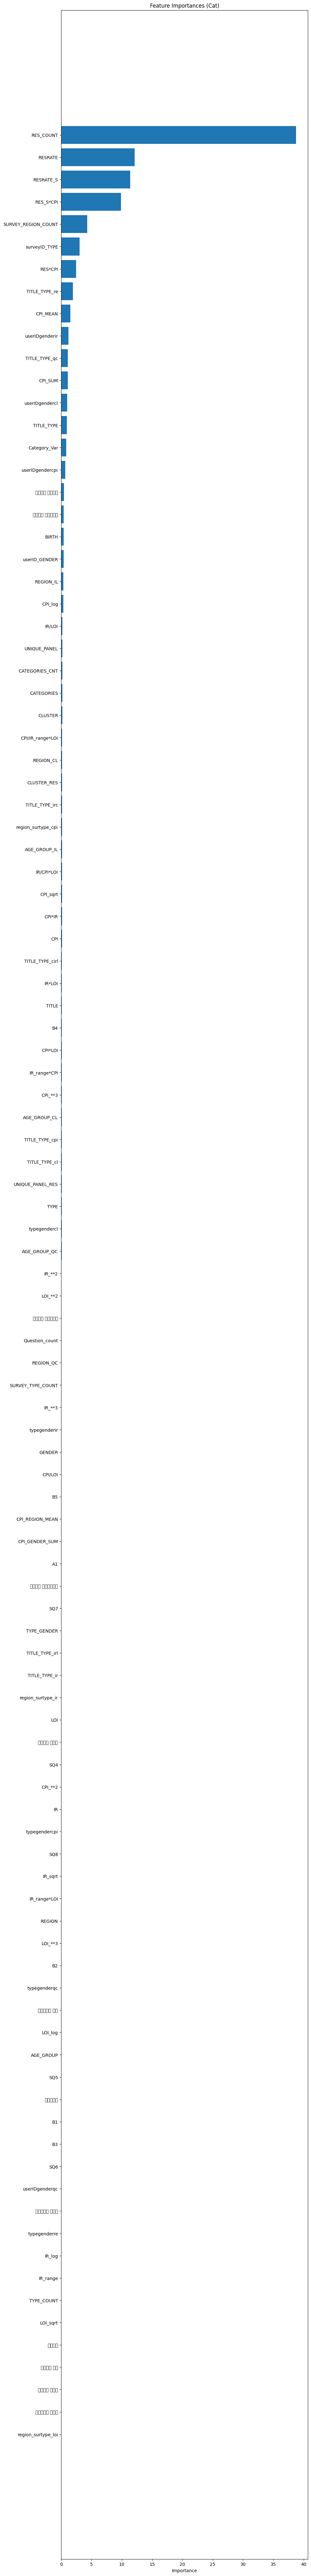

Model Tune for LGBM.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 316565, number of negative: 497085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.265279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8351
[LightGBM] [Info] Number of data points in the train set: 813650, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389068 -> initscore=-0.451232
[LightGBM] [Info] Start training from score -0.451232


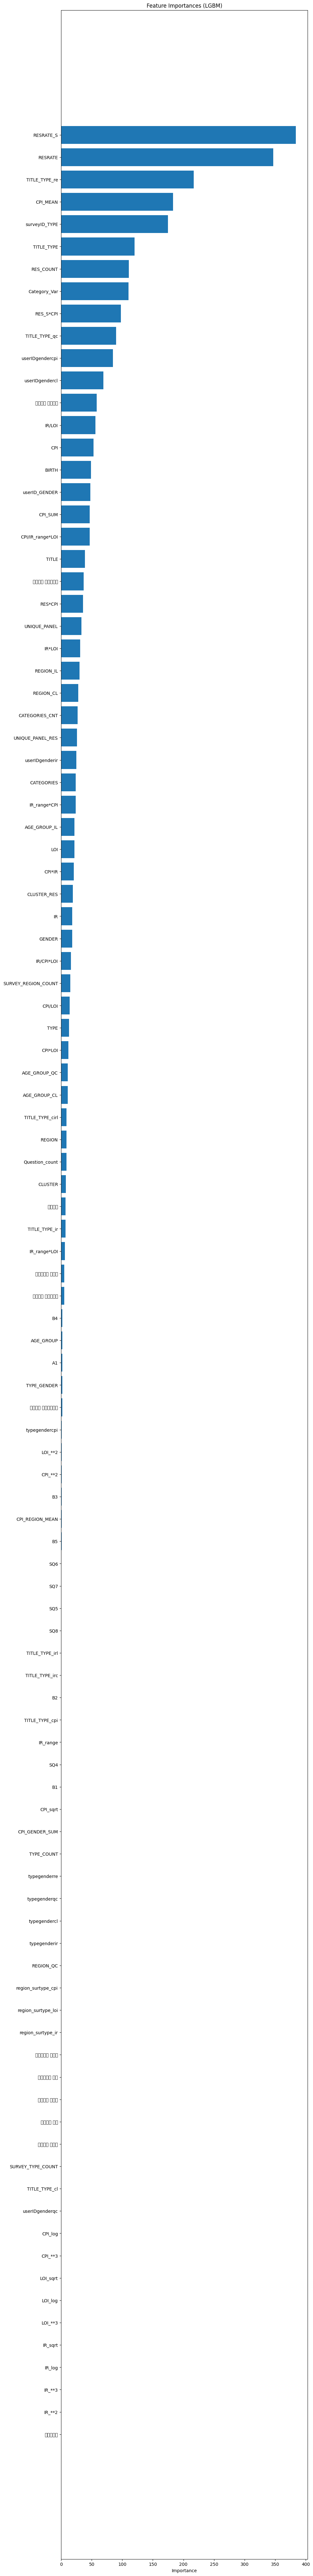

Model Tune for XGB.


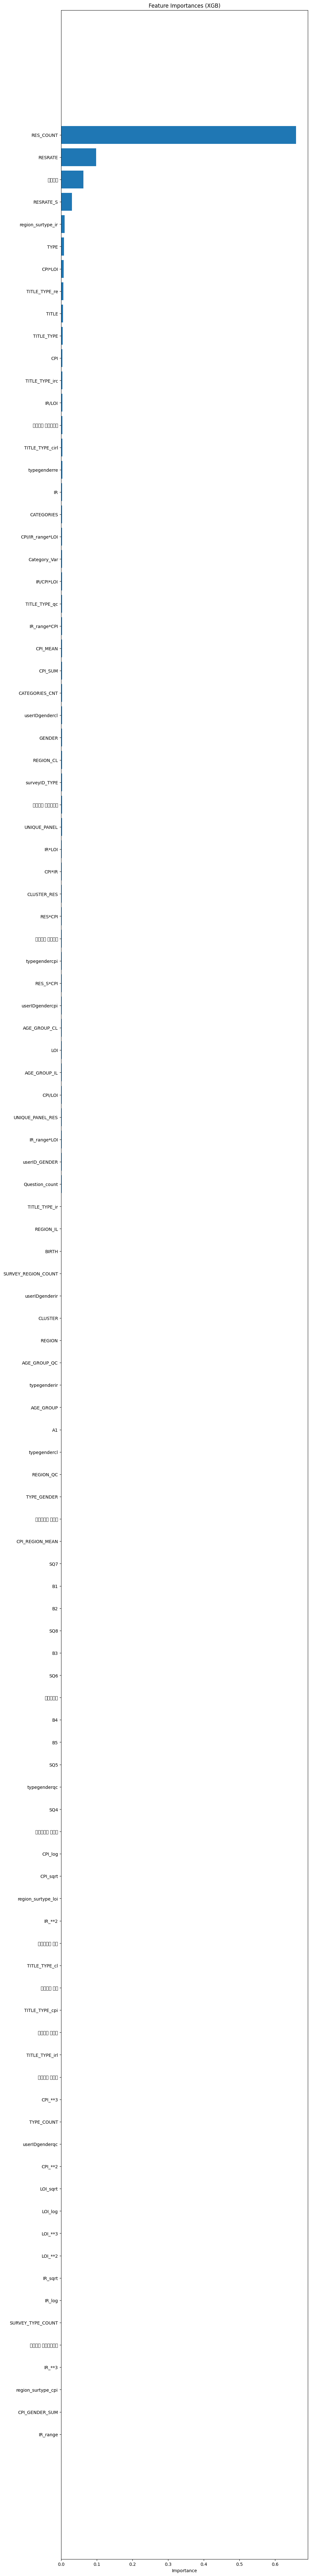

Model Tune for RandomForest.


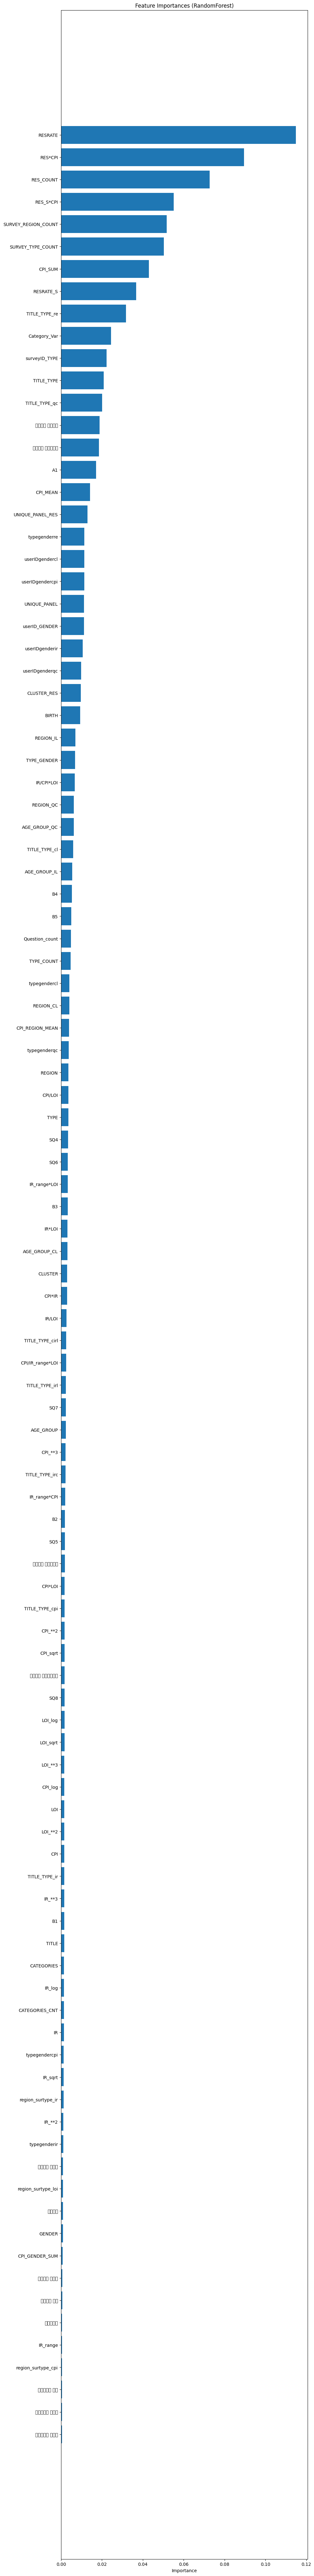

In [72]:
# 개별 모델별 Feature_importance 계산
cat_model, cat_feature_importances = train_and_evaluate(cat.CatBoostClassifier(), 'Cat', X_train, y_train)
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMClassifier(), 'LGBM', X_train, y_train)
xgb_model, xgb_feature_importances = train_and_evaluate(xgb.XGBClassifier(), 'XGB', X_train, y_train)
rf_model, rf_feature_importances = train_and_evaluate(RandomForestClassifier(), 'RandomForest', X_train, y_train)

##### 다수의 실험을 통해 모델별 최적 threshold 임계치 설정

In [73]:
threshold_cat = 0.05
low_importance_features_cat = X_train.columns[cat_feature_importances <= threshold_cat]

X_train_cat = X_train.drop(columns=low_importance_features_cat)
X_test_cat = X_test.drop(columns=low_importance_features_cat)


In [74]:
threshold_xgb = 0.001
low_importance_features_xgb = X_train.columns[xgb_feature_importances <= threshold_xgb]

X_train_xgb = X_train.drop(columns=low_importance_features_xgb)
X_test_xgb = X_test.drop(columns=low_importance_features_xgb)

In [75]:
threshold_lgbm = 10
low_importance_features_lgbm = X_train.columns[lgbm_feature_importances <= threshold_lgbm]

X_train_lgbm = X_train.drop(columns=low_importance_features_lgbm)
X_test_lgbm = X_test.drop(columns=low_importance_features_lgbm)


In [76]:
threshold_rf = 0.005
low_importance_features_rf = X_train.columns[rf_feature_importances <= threshold_rf]

X_train_rf = X_train.drop(columns=low_importance_features_rf)
X_test_rf = X_test.drop(columns=low_importance_features_rf)

## MODELING(CatBoost, XGB, LGBM, RandomForest)

##### CATBOOST 

In [107]:
# 실험을 통해 catboost 모형에 catboost_feature_importance set보다 xgb_feature_importance set을 input으로 넣었을때 더 성능이 우수한 것으로 확인
# 개별 모델 파라미터 튜닝1 - CAT

import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def objective(trial, X_train_cat, y_train):
    # 하이퍼파라미터 값 튜닝 구간 지정
    param = {
        'iterations': trial.suggest_int('iterations', 800, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        'random_strength': trial.suggest_uniform('random_strength', 1e-9, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'l2_leaf_reg': trial.suggest_uniform('l2_leaf_reg', 1e-2, 10),
        'random_state': 20202655
    }

    # 데이터 분할
    X_train_cat, X_val_cat, y_train, y_val = train_test_split(X_train_xgb, y_train, test_size=0.1, random_state=10)

    # 모델 생성 및 훈련
    model = CatBoostClassifier(**param)
    model.fit(X_train_cat, y_train, verbose=0)

    # 예측 및 평가
    preds = model.predict(X_val_cat)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

# Optuna study 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_cat, y_train), n_trials=50)

# 최적의 하이퍼파라미터 출력
best_params = study.best_trial.params
print("Best trial:", best_params)

# 최적성능 출력
best_score = study.best_value
print("Best score:", best_score)

[I 2023-12-20 15:07:11,381] A new study created in memory with name: no-name-376f1ff7-516d-4ccf-abec-368abd35e2e8
[I 2023-12-20 15:08:39,980] Trial 0 finished with value: 0.8732378786947704 and parameters: {'iterations': 1194, 'depth': 10, 'learning_rate': 0.04966728506520016, 'random_strength': 6.832164184101616, 'bagging_temperature': 0.7000999645842231, 'l2_leaf_reg': 1.7589988141121817}. Best is trial 0 with value: 0.8732378786947704.
[I 2023-12-20 15:09:10,440] Trial 1 finished with value: 0.8730658145394211 and parameters: {'iterations': 825, 'depth': 8, 'learning_rate': 0.06834068161751028, 'random_strength': 2.975423049130984, 'bagging_temperature': 0.3212412732367146, 'l2_leaf_reg': 3.9552922677700546}. Best is trial 0 with value: 0.8732378786947704.
[I 2023-12-20 15:10:11,621] Trial 2 finished with value: 0.8722915258403491 and parameters: {'iterations': 824, 'depth': 10, 'learning_rate': 0.03873682534176646, 'random_strength': 7.662019862075814, 'bagging_temperature': 0.6231

Best trial: {'iterations': 1244, 'depth': 10, 'learning_rate': 0.05622438672976206, 'random_strength': 1.8665210745867893, 'bagging_temperature': 0.9261027314562652, 'l2_leaf_reg': 7.294763946637379}
Best score: 0.8746881337184294


In [108]:
# 최적 파라미터 기반 모델 학습
final_cat_model = CatBoostClassifier(**best_params)
final_cat_model.fit(X_train_cat, y_train, verbose=0)

In [109]:
# 최적 모델을 통한 oof_prediction 생성
oof_model_cat = cross_validate(final_cat_model, # 최적화된 hyperparameter 사용
                        X_train_cat, y_train, cv=7, scoring='accuracy', 
                        return_estimator=True)
oof_pred_cat = np.array([m.predict_proba(X_test_cat)[:,1] for m in oof_model_cat['estimator']]).mean(axis=0)

0:	learn: 0.5918010	total: 119ms	remaining: 2m 27s
1:	learn: 0.5132844	total: 238ms	remaining: 2m 27s
2:	learn: 0.4741517	total: 365ms	remaining: 2m 30s
3:	learn: 0.4349263	total: 483ms	remaining: 2m 29s
4:	learn: 0.3964889	total: 606ms	remaining: 2m 30s
5:	learn: 0.3749060	total: 727ms	remaining: 2m 29s
6:	learn: 0.3589929	total: 847ms	remaining: 2m 29s
7:	learn: 0.3464140	total: 970ms	remaining: 2m 29s
8:	learn: 0.3354340	total: 1.09s	remaining: 2m 29s
9:	learn: 0.3258283	total: 1.22s	remaining: 2m 30s
10:	learn: 0.3148547	total: 1.34s	remaining: 2m 29s
11:	learn: 0.3037179	total: 1.47s	remaining: 2m 30s
12:	learn: 0.2953038	total: 1.58s	remaining: 2m 30s
13:	learn: 0.2906806	total: 1.7s	remaining: 2m 29s
14:	learn: 0.2849847	total: 1.83s	remaining: 2m 29s
15:	learn: 0.2818536	total: 1.95s	remaining: 2m 30s
16:	learn: 0.2788001	total: 2.08s	remaining: 2m 29s
17:	learn: 0.2761218	total: 2.2s	remaining: 2m 29s
18:	learn: 0.2737961	total: 2.33s	remaining: 2m 30s
19:	learn: 0.2703243	tot

##### XGB

In [80]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def objective(trial, X_train_xgb, y_train):
    # 하이퍼파라미터 값 튜닝 구간 지정
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
        'random_state': 20202655
    }
    X_train_xgb, X_val_xgb, y_train, y_val = train_test_split(X_train_xgb, y_train, test_size=0.1, random_state=10)
    
    # 모델 생성 및 훈련
    model = XGBClassifier(**param)
    model.fit(X_train_xgb, y_train)

    # 예측 및 평가
    preds = model.predict(X_val_xgb)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

# Optuna study 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_xgb, y_train), n_trials=50)

# 최적의 하이퍼파라미터 출력
best_params = study.best_trial.params
print("Best trial:", best_params)

# 최적성능 출력
best_score = study.best_value
print("Best score:", best_score)

[I 2023-12-20 09:43:59,721] A new study created in memory with name: no-name-9ed1c72d-4359-4401-accc-7e9120b8fc34
[I 2023-12-20 09:44:05,863] Trial 0 finished with value: 0.8683955017513673 and parameters: {'n_estimators': 410, 'max_depth': 18, 'learning_rate': 0.27515976137026504, 'min_child_weight': 7, 'subsample': 0.5530647388916353, 'colsample_bytree': 0.5470392992624383, 'gamma': 4.203057108402412, 'reg_alpha': 0.3578078833272552, 'reg_lambda': 0.9049208196413857}. Best is trial 0 with value: 0.8683955017513673.
[I 2023-12-20 09:44:12,145] Trial 1 finished with value: 0.8714803662508449 and parameters: {'n_estimators': 467, 'max_depth': 10, 'learning_rate': 0.1533272464209069, 'min_child_weight': 4, 'subsample': 0.6609331297996328, 'colsample_bytree': 0.9744371955765228, 'gamma': 4.250977133165468, 'reg_alpha': 0.9770446702836272, 'reg_lambda': 0.9852719526566287}. Best is trial 1 with value: 0.8714803662508449.
[I 2023-12-20 09:44:23,485] Trial 2 finished with value: 0.8721071713

Best trial: {'n_estimators': 473, 'max_depth': 8, 'learning_rate': 0.0798757578818634, 'min_child_weight': 3, 'subsample': 0.7818567435136724, 'colsample_bytree': 0.9255376937730064, 'gamma': 2.2548497653147908, 'reg_alpha': 0.695027421164171, 'reg_lambda': 0.8548652800202403}
Best score: 0.8735697167086585


In [81]:
# 최적 파라미터 기반 모델 학습
final_xgb_model = XGBClassifier(**best_params)
final_xgb_model.fit(X_train_xgb, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9255376937730064, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2.2548497653147908,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0798757578818634,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=473, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [82]:
# 최적 모델을 통한 oof_prediction 생성
oof_model_xgb = cross_validate(final_xgb_model, # 최적화된 hyperparameter 사용
                        X_train_xgb, y_train, cv=7, scoring='accuracy', 
                        return_estimator=True)
oof_pred_xgb = np.array([m.predict_proba(X_test_xgb)[:,1] for m in oof_model_xgb['estimator']]).mean(axis=0)

### LGBM

In [83]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def objective(trial, X_train_lgbm, y_train):
    # 하이퍼파라미터 값 튜닝 구간 지정
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': 20202655
    }
    
    X_train_lgbm, X_val_lgbm, y_train, y_val = train_test_split(X_train_lgbm, y_train, test_size=0.1, random_state=10)
    
    # 모델 생성 및 훈련
    model = LGBMClassifier(**param)
    model.fit(X_train_lgbm, y_train)

    # 예측 및 평가
    preds = model.predict(X_val_lgbm)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

# Optuna study 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_lgbm, y_train), n_trials=50)

# 최적의 하이퍼파라미터 출력
best_params = study.best_trial.params
print("Best trial:", best_params)

# 최적성능 출력
best_score = study.best_value
print("Best score:", best_score)

[I 2023-12-20 09:57:15,455] A new study created in memory with name: no-name-ddc668c2-c41e-466e-8321-0d79b570641c


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 09:57:40,477] Trial 0 finished with value: 0.8689116942174153 and parameters: {'num_leaves': 20, 'max_depth': 8, 'learning_rate': 0.05171065289595037, 'n_estimators': 573, 'min_child_samples': 49, 'subsample': 0.81390703611632, 'colsample_bytree': 0.5537143979983361, 'reg_alpha': 5.747728801825148e-08, 'reg_lambda': 0.28326892290093914}. Best is trial 0 with value: 0.8689116942174153.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-12-20 09:58:02,302] Trial 1 finished with value: 0.8705340133964236 and parameters: {'num_leaves': 158, 'max_depth': 6, 'learning_rate': 0.06679325341541496, 'n_estimators': 430, 'min_child_samples': 72, 'subsample': 0.7819764963848799, 'colsample_bytree': 0.8192902183952693, 'reg_alpha': 2.6985985720434557e-05, 'reg_lambda': 2.523749773751251e-07}. Best is trial 1 with value: 0.8705340133964236.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-12-20 09:58:16,041] Trial 2 finished with value: 0.871996558716893 and parameters: {'num_leaves': 255, 'max_depth': 12, 'learning_rate': 0.06955363763542834, 'n_estimators': 186, 'min_child_samples': 13, 'subsample': 0.9542191674955227, 'colsample_bytree': 0.5084373126435471, 'reg_alpha': 1.3524507831146782e-08, 'reg_lambda': 2.820707660369095}. Best is trial 2 with value: 0.871996558716893.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 09:58:26,044] Trial 3 finished with value: 0.868370921157746 and parameters: {'num_leaves': 59, 'max_depth': 10, 'learning_rate': 0.06265732495337281, 'n_estimators': 149, 'min_child_samples': 49, 'subsample': 0.8086708526128221, 'colsample_bytree': 0.5320081174826158, 'reg_alpha': 3.8157726254220985, 'reg_lambda': 3.5082771699328425e-06}. Best is trial 2 with value: 0.871996558716893.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-12-20 09:59:12,386] Trial 4 finished with value: 0.8730658145394211 and parameters: {'num_leaves': 94, 'max_depth': 8, 'learning_rate': 0.08385517654289341, 'n_estimators': 956, 'min_child_samples': 73, 'subsample': 0.582500157968564, 'colsample_bytree': 0.6061736637197227, 'reg_alpha': 0.0011793079025696311, 'reg_lambda': 0.00902073780776828}. Best is trial 4 with value: 0.8730658145394211.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-12-20 09:59:53,078] Trial 5 finished with value: 0.8731149757266637 and parameters: {'num_leaves': 165, 'max_depth': 9, 'learning_rate': 0.06661806633279876, 'n_estimators': 630, 'min_child_samples': 98, 'subsample': 0.5177991543554147, 'colsample_bytree': 0.5908351298163548, 'reg_alpha': 6.113837890719306, 'reg_lambda': 2.900207945283384}. Best is trial 5 with value: 0.8731149757266637.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-12-20 10:00:14,772] Trial 6 finished with value: 0.870964173784797 and parameters: {'num_leaves': 211, 'max_depth': 12, 'learning_rate': 0.031428578577522674, 'n_estimators': 283, 'min_child_samples': 70, 'subsample': 0.8798721474436368, 'colsample_bytree': 0.5262680049283482, 'reg_alpha': 1.2695383297206304, 'reg_lambda': 1.5125598703496114e-08}. Best is trial 5 with value: 0.8731149757266637.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-12-20 10:00:45,356] Trial 7 finished with value: 0.8727954280095864 and parameters: {'num_leaves': 242, 'max_depth': 9, 'learning_rate': 0.06251777101112202, 'n_estimators': 458, 'min_child_samples': 17, 'subsample': 0.8000649356020996, 'colsample_bytree': 0.9857640562404961, 'reg_alpha': 0.00010567563870360382, 'reg_lambda': 1.9294895125140647e-06}. Best is trial 5 with value: 0.8731149757266637.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-12-20 10:01:16,383] Trial 8 finished with value: 0.8725987832606158 and parameters: {'num_leaves': 142, 'max_depth': 10, 'learning_rate': 0.09763390773251825, 'n_estimators': 663, 'min_child_samples': 9, 'subsample': 0.9805475904112462, 'colsample_bytree': 0.7654694863703877, 'reg_alpha': 3.5427527099634674e-06, 'reg_lambda': 1.1237228240566885e-06}. Best is trial 5 with value: 0.8731149757266637.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:01:42,697] Trial 9 finished with value: 0.872549622073373 and parameters: {'num_leaves': 122, 'max_depth': 15, 'learning_rate': 0.09261476080328662, 'n_estimators': 521, 'min_child_samples': 90, 'subsample': 0.6510635669086009, 'colsample_bytree': 0.7303527831540918, 'reg_alpha': 3.0232958992461682e-05, 'reg_lambda': 8.318282216185425e-08}. Best is trial 5 with value: 0.8731149757266637.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-12-20 10:02:13,955] Trial 10 finished with value: 0.8568303324525287 and parameters: {'num_leaves': 295, 'max_depth': 3, 'learning_rate': 0.008126897444519762, 'n_estimators': 804, 'min_child_samples': 99, 'subsample': 0.5116620733561403, 'colsample_bytree': 0.6407763817950551, 'reg_alpha': 0.05659154434742174, 'reg_lambda': 7.07134854542176}. Best is trial 5 with value: 0.8731149757266637.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:02:55,099] Trial 11 finished with value: 0.8730043630553678 and parameters: {'num_leaves': 92, 'max_depth': 19, 'learning_rate': 0.08315737658956832, 'n_estimators': 981, 'min_child_samples': 82, 'subsample': 0.5057763344369426, 'colsample_bytree': 0.6393165022542049, 'reg_alpha': 0.011836817818552994, 'reg_lambda': 0.010482886873410193}. Best is trial 5 with value: 0.8731149757266637.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-12-20 10:03:35,846] Trial 12 finished with value: 0.8720088490137037 and parameters: {'num_leaves': 183, 'max_depth': 5, 'learning_rate': 0.08022199576188455, 'n_estimators': 979, 'min_child_samples': 66, 'subsample': 0.6091350357516436, 'colsample_bytree': 0.62603019373473, 'reg_alpha': 0.00612430154690476, 'reg_lambda': 0.0031463862134011793}. Best is trial 5 with value: 0.8731149757266637.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:04:18,308] Trial 13 finished with value: 0.8732378786947704 and parameters: {'num_leaves': 101, 'max_depth': 15, 'learning_rate': 0.08140610080217242, 'n_estimators': 784, 'min_child_samples': 99, 'subsample': 0.6154472155782182, 'colsample_bytree': 0.605586293734509, 'reg_alpha': 7.92104670516144, 'reg_lambda': 0.07100799273749021}. Best is trial 13 with value: 0.8732378786947704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:05:11,172] Trial 14 finished with value: 0.8728568794936398 and parameters: {'num_leaves': 180, 'max_depth': 16, 'learning_rate': 0.04918178411471191, 'n_estimators': 768, 'min_child_samples': 100, 'subsample': 0.6905640141082352, 'colsample_bytree': 0.6866986514343699, 'reg_alpha': 9.409436825745544, 'reg_lambda': 0.2833351751220786}. Best is trial 13 with value: 0.8732378786947704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:05:45,546] Trial 15 finished with value: 0.8723406870275917 and parameters: {'num_leaves': 102, 'max_depth': 15, 'learning_rate': 0.09667550390754626, 'n_estimators': 770, 'min_child_samples': 39, 'subsample': 0.5755224835390911, 'colsample_bytree': 0.57384158397578, 'reg_alpha': 0.31237932509515387, 'reg_lambda': 0.0001014658841490336}. Best is trial 13 with value: 0.8732378786947704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:06:15,576] Trial 16 finished with value: 0.872107171388189 and parameters: {'num_leaves': 51, 'max_depth': 20, 'learning_rate': 0.07484277514555142, 'n_estimators': 655, 'min_child_samples': 87, 'subsample': 0.697863055667316, 'colsample_bytree': 0.5890934505247585, 'reg_alpha': 0.2593499239453669, 'reg_lambda': 0.3092599918353417}. Best is trial 13 with value: 0.8732378786947704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:06:58,638] Trial 17 finished with value: 0.8732747495852025 and parameters: {'num_leaves': 133, 'max_depth': 17, 'learning_rate': 0.08489048873667122, 'n_estimators': 832, 'min_child_samples': 36, 'subsample': 0.5575438187347896, 'colsample_bytree': 0.6807325428949839, 'reg_alpha': 5.079633372997125, 'reg_lambda': 5.154814012278856}. Best is trial 17 with value: 0.8732747495852025.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:07:36,930] Trial 18 finished with value: 0.8726725250414797 and parameters: {'num_leaves': 123, 'max_depth': 17, 'learning_rate': 0.08830127226742657, 'n_estimators': 859, 'min_child_samples': 29, 'subsample': 0.6391260453872225, 'colsample_bytree': 0.6862276860411236, 'reg_alpha': 0.6944596844046996, 'reg_lambda': 0.08657653209883286}. Best is trial 17 with value: 0.8732747495852025.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:08:09,789] Trial 19 finished with value: 0.8720088490137037 and parameters: {'num_leaves': 45, 'max_depth': 18, 'learning_rate': 0.09710139161447733, 'n_estimators': 870, 'min_child_samples': 28, 'subsample': 0.5660494337076645, 'colsample_bytree': 0.5041082221969815, 'reg_alpha': 0.04772299407490491, 'reg_lambda': 0.0008309736083922495}. Best is trial 17 with value: 0.8732747495852025.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:08:43,716] Trial 20 finished with value: 0.8725373317765625 and parameters: {'num_leaves': 76, 'max_depth': 14, 'learning_rate': 0.07864802796079405, 'n_estimators': 719, 'min_child_samples': 61, 'subsample': 0.7139916465730701, 'colsample_bytree': 0.6758798702838158, 'reg_alpha': 1.2666588613862308, 'reg_lambda': 6.973338122333138}. Best is trial 17 with value: 0.8732747495852025.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:09:18,109] Trial 21 finished with value: 0.8732624592883919 and parameters: {'num_leaves': 130, 'max_depth': 17, 'learning_rate': 0.08624880110885465, 'n_estimators': 605, 'min_child_samples': 40, 'subsample': 0.5392705577468118, 'colsample_bytree': 0.5784984133476353, 'reg_alpha': 9.136363444848259, 'reg_lambda': 1.0373945525537391}. Best is trial 17 with value: 0.8732747495852025.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:10:03,172] Trial 22 finished with value: 0.8734959749277945 and parameters: {'num_leaves': 130, 'max_depth': 14, 'learning_rate': 0.08813822554114072, 'n_estimators': 869, 'min_child_samples': 40, 'subsample': 0.55569382550096, 'colsample_bytree': 0.5731075007129706, 'reg_alpha': 6.66980975626232, 'reg_lambda': 0.0562126634052383}. Best is trial 22 with value: 0.8734959749277945.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:10:43,703] Trial 23 finished with value: 0.8725004608861304 and parameters: {'num_leaves': 128, 'max_depth': 13, 'learning_rate': 0.09085899903673327, 'n_estimators': 876, 'min_child_samples': 36, 'subsample': 0.5572524671319249, 'colsample_bytree': 0.5740034424015291, 'reg_alpha': 0.1181033043720632, 'reg_lambda': 0.8879426295028402}. Best is trial 22 with value: 0.8734959749277945.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:11:25,458] Trial 24 finished with value: 0.8735328458182265 and parameters: {'num_leaves': 149, 'max_depth': 17, 'learning_rate': 0.09973736495761776, 'n_estimators': 910, 'min_child_samples': 42, 'subsample': 0.5516331351465922, 'colsample_bytree': 0.5496871217592542, 'reg_alpha': 1.2665812143824065, 'reg_lambda': 0.7848145909440525}. Best is trial 24 with value: 0.8735328458182265.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:12:09,703] Trial 25 finished with value: 0.8728937503840718 and parameters: {'num_leaves': 196, 'max_depth': 20, 'learning_rate': 0.09983680906175499, 'n_estimators': 905, 'min_child_samples': 24, 'subsample': 0.543816178952739, 'colsample_bytree': 0.5446541440827584, 'reg_alpha': 1.0569640405822829, 'reg_lambda': 8.503358957538737}. Best is trial 24 with value: 0.8735328458182265.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:12:42,189] Trial 26 finished with value: 0.8720948810913783 and parameters: {'num_leaves': 153, 'max_depth': 18, 'learning_rate': 0.09026889100458589, 'n_estimators': 711, 'min_child_samples': 56, 'subsample': 0.6054503846519906, 'colsample_bytree': 0.5029634307038517, 'reg_alpha': 0.2716231911515939, 'reg_lambda': 0.0437860988902298}. Best is trial 24 with value: 0.8735328458182265.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:13:28,222] Trial 27 finished with value: 0.8733362010692558 and parameters: {'num_leaves': 219, 'max_depth': 14, 'learning_rate': 0.07543757080919607, 'n_estimators': 919, 'min_child_samples': 44, 'subsample': 0.6470158888898357, 'colsample_bytree': 0.551310047684266, 'reg_alpha': 1.1229947402371647, 'reg_lambda': 1.3731386152797531}. Best is trial 24 with value: 0.8735328458182265.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-12-20 10:14:15,229] Trial 28 finished with value: 0.872512751182941 and parameters: {'num_leaves': 235, 'max_depth': 13, 'learning_rate': 0.07578754276507811, 'n_estimators': 929, 'min_child_samples': 45, 'subsample': 0.6616719213895321, 'colsample_bytree': 0.5502409341575867, 'reg_alpha': 0.012238701305177308, 'reg_lambda': 1.0625969325119395}. Best is trial 24 with value: 0.8735328458182265.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:14:20,720] Trial 29 finished with value: 0.8694893381675167 and parameters: {'num_leaves': 202, 'max_depth': 14, 'learning_rate': 0.0996819055726461, 'n_estimators': 53, 'min_child_samples': 53, 'subsample': 0.6032856452832402, 'colsample_bytree': 0.5394309742212634, 'reg_alpha': 0.05978018414409712, 'reg_lambda': 0.2053164688382709}. Best is trial 24 with value: 0.8735328458182265.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:14:58,529] Trial 30 finished with value: 0.8721317519818104 and parameters: {'num_leaves': 20, 'max_depth': 16, 'learning_rate': 0.08960895377004092, 'n_estimators': 1000, 'min_child_samples': 45, 'subsample': 0.6482583637263363, 'colsample_bytree': 0.5563839065056272, 'reg_alpha': 1.9253179572626442, 'reg_lambda': 0.5434634103304066}. Best is trial 24 with value: 0.8735328458182265.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:15:43,412] Trial 31 finished with value: 0.8722915258403491 and parameters: {'num_leaves': 222, 'max_depth': 17, 'learning_rate': 0.08644945735767004, 'n_estimators': 833, 'min_child_samples': 32, 'subsample': 0.538859242230219, 'colsample_bytree': 0.6197717793475416, 'reg_alpha': 2.429779332266006, 'reg_lambda': 1.693228834263336}. Best is trial 24 with value: 0.8735328458182265.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:16:17,861] Trial 32 finished with value: 0.8729183309776931 and parameters: {'num_leaves': 164, 'max_depth': 14, 'learning_rate': 0.09334081309566108, 'n_estimators': 724, 'min_child_samples': 20, 'subsample': 0.5773368758717059, 'colsample_bytree': 0.5595874666398045, 'reg_alpha': 0.47341513730016804, 'reg_lambda': 0.20631889984497023}. Best is trial 24 with value: 0.8735328458182265.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-12-20 10:17:08,848] Trial 33 finished with value: 0.8722669452467277 and parameters: {'num_leaves': 267, 'max_depth': 11, 'learning_rate': 0.07491861232159064, 'n_estimators': 923, 'min_child_samples': 44, 'subsample': 0.5017267306273224, 'colsample_bytree': 0.5263835721830165, 'reg_alpha': 2.2990325448686244, 'reg_lambda': 2.508749571000305}. Best is trial 24 with value: 0.8735328458182265.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:17:48,545] Trial 34 finished with value: 0.8738523935353039 and parameters: {'num_leaves': 144, 'max_depth': 16, 'learning_rate': 0.07101578804880462, 'n_estimators': 838, 'min_child_samples': 35, 'subsample': 0.7530118441603849, 'colsample_bytree': 0.5006901166829932, 'reg_alpha': 3.2186996975937507, 'reg_lambda': 0.03687508736427751}. Best is trial 34 with value: 0.8738523935353039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:18:09,103] Trial 35 finished with value: 0.872033429607325 and parameters: {'num_leaves': 181, 'max_depth': 13, 'learning_rate': 0.06809508583775696, 'n_estimators': 355, 'min_child_samples': 50, 'subsample': 0.7279962039299395, 'colsample_bytree': 0.5034267012634663, 'reg_alpha': 0.5866916415238062, 'reg_lambda': 0.024611723520195486}. Best is trial 34 with value: 0.8738523935353039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:18:52,536] Trial 36 finished with value: 0.8728200086032077 and parameters: {'num_leaves': 151, 'max_depth': 16, 'learning_rate': 0.07267516773853781, 'n_estimators': 942, 'min_child_samples': 56, 'subsample': 0.7726288279996963, 'colsample_bytree': 0.5324735274864233, 'reg_alpha': 0.17230771193835778, 'reg_lambda': 0.037932874364620645}. Best is trial 34 with value: 0.8738523935353039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-12-20 10:19:22,588] Trial 37 finished with value: 0.8727708474159651 and parameters: {'num_leaves': 169, 'max_depth': 11, 'learning_rate': 0.07957096292689878, 'n_estimators': 530, 'min_child_samples': 33, 'subsample': 0.7504031907322923, 'colsample_bytree': 0.5894984522918202, 'reg_alpha': 2.2003385915622333, 'reg_lambda': 0.13483686554668492}. Best is trial 34 with value: 0.8738523935353039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:20:03,010] Trial 38 finished with value: 0.8728814600872611 and parameters: {'num_leaves': 115, 'max_depth': 18, 'learning_rate': 0.06143210153532636, 'n_estimators': 888, 'min_child_samples': 44, 'subsample': 0.6727635911748537, 'colsample_bytree': 0.5287609562380956, 'reg_alpha': 0.6480520409063428, 'reg_lambda': 0.7130543645237113}. Best is trial 34 with value: 0.8738523935353039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:20:42,863] Trial 39 finished with value: 0.8735574264118479 and parameters: {'num_leaves': 143, 'max_depth': 12, 'learning_rate': 0.09270343145644316, 'n_estimators': 819, 'min_child_samples': 25, 'subsample': 0.6316604954004118, 'colsample_bytree': 0.560134358122885, 'reg_alpha': 3.1981909041848025, 'reg_lambda': 0.013563039241718105}. Best is trial 34 with value: 0.8738523935353039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:21:18,387] Trial 40 finished with value: 0.8732010078043385 and parameters: {'num_leaves': 143, 'max_depth': 12, 'learning_rate': 0.09250112802430192, 'n_estimators': 692, 'min_child_samples': 13, 'subsample': 0.5912972180747244, 'colsample_bytree': 0.6056541995670609, 'reg_alpha': 3.4793690997372044, 'reg_lambda': 0.009170288297643183}. Best is trial 34 with value: 0.8738523935353039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:21:58,978] Trial 41 finished with value: 0.8727339765255331 and parameters: {'num_leaves': 143, 'max_depth': 14, 'learning_rate': 0.08502461651785967, 'n_estimators': 820, 'min_child_samples': 24, 'subsample': 0.6335018133664828, 'colsample_bytree': 0.5626502626022645, 'reg_alpha': 3.500118694956279, 'reg_lambda': 0.024447238077347277}. Best is trial 34 with value: 0.8738523935353039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-12-20 10:22:34,381] Trial 42 finished with value: 0.8732255883979598 and parameters: {'num_leaves': 160, 'max_depth': 10, 'learning_rate': 0.09421587429413816, 'n_estimators': 756, 'min_child_samples': 40, 'subsample': 0.683803712389897, 'colsample_bytree': 0.501076445262717, 'reg_alpha': 0.9120067988081507, 'reg_lambda': 0.0989212708802726}. Best is trial 34 with value: 0.8738523935353039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:23:19,067] Trial 43 finished with value: 0.8728200086032077 and parameters: {'num_leaves': 108, 'max_depth': 15, 'learning_rate': 0.09454981717368152, 'n_estimators': 951, 'min_child_samples': 25, 'subsample': 0.6363181652329604, 'colsample_bytree': 0.5334813814486113, 'reg_alpha': 7.74701089349602, 'reg_lambda': 0.4049548348662547}. Best is trial 34 with value: 0.8738523935353039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:23:58,306] Trial 44 finished with value: 0.8734591040373625 and parameters: {'num_leaves': 85, 'max_depth': 13, 'learning_rate': 0.07127089061314412, 'n_estimators': 850, 'min_child_samples': 6, 'subsample': 0.5273942357993093, 'colsample_bytree': 0.5598735418291405, 'reg_alpha': 0.14566520024027974, 'reg_lambda': 2.529945478613215}. Best is trial 34 with value: 0.8738523935353039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-12-20 10:24:40,161] Trial 45 finished with value: 0.8730658145394211 and parameters: {'num_leaves': 79, 'max_depth': 7, 'learning_rate': 0.0817700760573977, 'n_estimators': 846, 'min_child_samples': 20, 'subsample': 0.5269573635350226, 'colsample_bytree': 0.5909781594813324, 'reg_alpha': 2.5137884475826366, 'reg_lambda': 0.004119044067280763}. Best is trial 34 with value: 0.8738523935353039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:25:14,879] Trial 46 finished with value: 0.8728322989000185 and parameters: {'num_leaves': 82, 'max_depth': 13, 'learning_rate': 0.07078235518553587, 'n_estimators': 797, 'min_child_samples': 9, 'subsample': 0.5226533547682735, 'colsample_bytree': 0.5219780442127132, 'reg_alpha': 0.12826461087406002, 'reg_lambda': 2.414987249870592}. Best is trial 34 with value: 0.8738523935353039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-12-20 10:25:46,988] Trial 47 finished with value: 0.8728322989000185 and parameters: {'num_leaves': 118, 'max_depth': 9, 'learning_rate': 0.08773154662678799, 'n_estimators': 560, 'min_child_samples': 14, 'subsample': 0.501275201234302, 'colsample_bytree': 0.5691216893293105, 'reg_alpha': 9.785193139153428, 'reg_lambda': 0.10275241870805407}. Best is trial 34 with value: 0.8738523935353039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:26:06,754] Trial 48 finished with value: 0.8714803662508449 and parameters: {'num_leaves': 92, 'max_depth': 11, 'learning_rate': 0.09994119355755585, 'n_estimators': 408, 'min_child_samples': 6, 'subsample': 0.574793066746881, 'colsample_bytree': 0.6470981326393958, 'reg_alpha': 0.0010698021871436221, 'reg_lambda': 0.019625669281490014}. Best is trial 34 with value: 0.8738523935353039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 284983, number of negative: 447302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 732285, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389170 -> initscore=-0.450804
[LightGBM] [Info] Start training from score -0.450804


[I 2023-12-20 10:26:40,422] Trial 49 finished with value: 0.8728691697904505 and parameters: {'num_leaves': 71, 'max_depth': 12, 'learning_rate': 0.06354616257920417, 'n_estimators': 744, 'min_child_samples': 18, 'subsample': 0.8224108060695523, 'colsample_bytree': 0.6055955286807994, 'reg_alpha': 0.3665357178508932, 'reg_lambda': 0.282612827195289}. Best is trial 34 with value: 0.8738523935353039.


Best trial: {'num_leaves': 144, 'max_depth': 16, 'learning_rate': 0.07101578804880462, 'n_estimators': 838, 'min_child_samples': 35, 'subsample': 0.7530118441603849, 'colsample_bytree': 0.5006901166829932, 'reg_alpha': 3.2186996975937507, 'reg_lambda': 0.03687508736427751}
Best score: 0.8738523935353039


In [84]:
# 최적 파라미터 기반 모델 학습
final_lgbm_model = LGBMClassifier(**best_params)
final_lgbm_model.fit(X_train_lgbm, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 316565, number of negative: 497085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6304
[LightGBM] [Info] Number of data points in the train set: 813650, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389068 -> initscore=-0.451232
[LightGBM] [Info] Start training from score -0.451232


LGBMClassifier(colsample_bytree=0.5006901166829932,
               learning_rate=0.07101578804880462, max_depth=16,
               min_child_samples=35, n_estimators=838, num_leaves=144,
               reg_alpha=3.2186996975937507, reg_lambda=0.03687508736427751,
               subsample=0.7530118441603849)

In [85]:
# 최적 모델을 통한 oof_prediction 생성
oof_model_lgbm = cross_validate(final_lgbm_model, # 최적화된 hyperparameter 사용
                        X_train_lgbm, y_train, cv=7, scoring='accuracy', 
                        return_estimator=True)
oof_pred_lgbm = np.array([m.predict_proba(X_test_lgbm)[:,1] for m in oof_model_lgbm['estimator']]).mean(axis=0)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 271341, number of negative: 426073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6307
[LightGBM] [Info] Number of data points in the train set: 697414, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389067 -> initscore=-0.451234
[LightGBM] [Info] Start training from score -0.451234
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 271341, number of negative: 426073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

#### RANDOMFOREST


In [96]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Objective function 정의
def objective(trial, X_train_rf, y_train):
    # 하이퍼파라미터 값 튜닝 구간 지정
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 20202655
    }
    X_train_rf, X_val_rf, y_train, y_val = train_test_split(X_train_rf, y_train, test_size=0.1, random_state=10)

    # 모델 생성 및 훈련
    model = RandomForestClassifier(**param)
    model.fit(X_train_rf, y_train)

    # 예측 및 평가
    preds = model.predict(X_val_rf)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

# Optuna study 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_rf, y_train), n_trials=10)

# 최적의 하이퍼파라미터 출력
best_params = study.best_trial.params
print("Best trial:", best_params)

# 최적성능 출력
best_score = study.best_value
print("Best score:", best_score)

[I 2023-12-20 12:26:08,589] A new study created in memory with name: no-name-dbfa9eb1-aa7c-403b-ab9e-23ec577931ff
[I 2023-12-20 12:33:18,201] Trial 0 finished with value: 0.8658268297179377 and parameters: {'n_estimators': 534, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8658268297179377.
[I 2023-12-20 12:38:36,836] Trial 1 finished with value: 0.8554169483193019 and parameters: {'n_estimators': 643, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8658268297179377.
[I 2023-12-20 12:46:00,317] Trial 2 finished with value: 0.8681005346279113 and parameters: {'n_estimators': 372, 'max_depth': 31, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 2 with value: 0.8681005346279113.
[I 2023-12-20 12:59:54,245] Trial 3 finished with value: 0.8683955017513673 a

Best trial: {'n_estimators': 237, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}
Best score: 0.8688994039206047


In [97]:
# 최적 파라미터 기반 모델 학습
final_rf_model = RandomForestClassifier(**best_params)
final_rf_model.fit(X_train_rf, y_train)

RandomForestClassifier(bootstrap=False, max_depth=29, min_samples_leaf=9,
                       min_samples_split=7, n_estimators=237)

In [98]:
# 최적 모델을 통한 oof_prediction 생성
oof_model_rf = cross_validate(final_rf_model, # 최적화된 hyperparameter 사용
                        X_train_rf, y_train, cv=7, scoring='accuracy', 
                        return_estimator=True)
oof_pred_rf = np.array([m.predict_proba(X_test_rf)[:,1] for m in oof_model_rf['estimator']]).mean(axis=0)

## VOTING

In [110]:
# 개별모델 성능 비교에 따른 가중치 부여
weights = {'lgbm': 0.3, 'xgb': 0.2, 'cat': 0.4, 'rf': 0.1}

# 개별 모델의 oof_prediction에 모델별 가중치 적용
weighted_prob_lgbm = oof_pred_lgbm * weights['lgbm']
weighted_prob_xgb = oof_pred_xgb * weights['xgb']
weighted_prob_cat = oof_pred_cat * weights['cat']
weighted_prob_rf = oof_pred_rf * weights['rf']

# 가중 평균 확률 계산
total_weighted_prob = weighted_prob_lgbm + weighted_prob_xgb + weighted_prob_cat +weighted_prob_rf
final_prob = total_weighted_prob / sum(weights.values())

# 임계치 기반 이진 분류
threshold = 0.495
final_predictions = (final_prob > threshold).astype(int)

In [111]:
# submission file 생성
pd.DataFrame({'ID': ID_test, 'STATUS':final_predictions}).to_csv('final_7.csv', index=False)

## END